# Исследование поведения пользователей приложения по продаже продуктов питания

<b> Описание проекта: </b> Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

<b> Цели проекта: </b> 
1. Составление воронки продаж.
2. Рекомендация к решению "Изменить шрифты во всём приложении".

<b> Задачи проекта: </b>
1. Изучить воронку продаж. 
2. Исследовать результаты A/A/B-эксперимента по изменению шрифтов во всём приложении.

<b> Описание данных: </b>
- Файл: logs_exp.csv
- Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Чтение файла с данными, изучение общей информации

In [1]:
# импортируем все необходимые для работы библиотеки
import pandas as pd
from datetime import date

from scipy import stats as st
import numpy as np
import math as mth

import matplotlib.pyplot as plt 
import seaborn as sns

In [9]:
data = pd.read_csv(path+'logs_exp.csv', sep='\t')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [11]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<b> Вывод 1: </b> прочла файл с логами. Датафрейм на 4 столбца и 244126 строк. Сразу бросаются в глаза названия столбцов - не по правилам питона. На первый взгляд нет пропусков в данных. Типы данных соответствуют содержанию, кроме столбца 'EventTimestamp' - необходимо будет разобраться с этим.

## Подготовка данных

In [12]:
# контрольный замер кол-ва строк
count_row = data.shape[0]

### Переименование стоблцов

In [13]:
data = data.rename(
    columns={
        'EventName' : 'event_name',
        'DeviceIDHash' : 'device_id_hash',
        'EventTimestamp' : 'event_timestamp',
        'ExpId' : 'exp_id'
    }
)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<b> Вывод 2.1: </b> переименовала столбцы в соответствии с правилами питона.

### Работа с пропусками и дубликатами

In [15]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков нет.

In [16]:
data.duplicated().sum()

413

Явных дубликатов 413. Посмотрим неявные:

In [17]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [18]:
data['event_name'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

В столбце event_name все значения уникальные. Больше всего показов главного экрана - MainScreenAppear. Далее разница больше чем в 2 раза - показ предложения (OffersScreenAppear) и показ корзины (CartScreenAppear).

In [19]:
data['exp_id'].unique()

array([246, 248, 247], dtype=int64)

In [20]:
data['exp_id'].value_counts()

248    85747
246    80304
247    78075
Name: exp_id, dtype: int64

В датафрейме 3 группы эксперимента (как и написано в задании) - 246 и 247 (контрольные группы), 248 (экспериментальная группа). Группы примерно равны между собой (различаются на 3-9%).

In [21]:
data['device_id_hash'].nunique()

7551

In [22]:
data['device_id_hash'].value_counts()

6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
1473604074272762258       1
4038665841336196550       1
6471198426894625455       1
8306004969579731119       1
1083512226259476085       1
Name: device_id_hash, Length: 7551, dtype: int64

Всего в логах есть информация о действиях 7551 уникальных пользователей. Причем некоторые очень активные (например, пользователь 6304868067479728361 с 2308 действиями), также есть пользователи всего с 1 действием (если путь пользователя начинается с показа главного экрана, то видимо это и есть показ главного экрана).

In [23]:
# посмотрим явные дубликаты
data[data.duplicated()]

,event_name,device_id_hash,event_timestamp,exp_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [24]:
# 413 дубликатов - это 0.17% от всех данных, поэтому их можно удалить
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Удалила 413 явных дубликатов. Интересно, почему они появились? Возможно стоит сообщить об этом дата-инженерам, возможно есть ошибка при сборе данных.

<b> Вывод 2.2: </b> проверила работу с пропусками и дубликатами в датафрейме: пропусков нет, удалены 413 явных дубликатов, нет неявных дубликатов.

### Работа с типами данных

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Есть вопросы только к столбцу с датой и временем события. Поэтому добавим в датафрейм 2 столбца: 1 - даты и времени, 2 - отдельный с датами.

In [26]:
# столбец с датой и временем
data['event_date_time'] = pd.to_datetime(data.event_timestamp, unit='s')

# отдельный столбец с датой
data['event_date'] = data['event_date_time'].dt.date

data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_date_time  243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


<b> Вывод 2.3: </b> в датафрейм добавлены 2 столбца: 1 - дата и время события, 2 - дата события.

<b> Вывод 2: </b> проведена подготовительная работа с данными: 
- переименованы столбцы, 
- датафрейм проверен на пропуски и дубликаты (явные и неявные), 
- были удалены 413 явных дубликатов, кол-во строк в датафрейме уменьшилось на 0.17%,
- добавлены 2 столбца: 1 - с датой и временем события, 2 - с датой события.

## Исследование данных

### Сколько всего событий в логе?

In [28]:
print('Всего событий в логе -', data['event_name'].nunique())

Всего событий в логе - 5


<b> Вывод 3.1: </b> всего событий в логе - 5

### Сколько всего пользователей в логе?

In [29]:
users_count = data['device_id_hash'].nunique()
print('Кол-во пользователей в логе -', users_count)

Кол-во пользователей в логе - 7551


<b> Вывод 3.2: </b> кол-во пользователей в логе - 7551

### Сколько в среднем событий приходится на пользователя?

In [30]:
# можно расчитать через статистический метод describe
data['device_id_hash'].value_counts().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: device_id_hash, dtype: float64

<b> Вывод 3.3: </b> среднее количество событий на пользователя - 32. При этом медианное значение = 20, а максимальное значение = 2307, отсюда и разница между медианой и средним.

### Данными за какой период вы располагаете?

In [31]:
# контрольный замер
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_date_time  243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [32]:
print('Максимальная дата -', data['event_date'].max())

Максимальная дата - 2019-08-07


In [33]:
print('Минимальная дата -', data['event_date'].min())

Минимальная дата - 2019-07-25


Получили, что есть данные в период с 25 июля 2019 по 07 августа 2019. Это 14 дней.

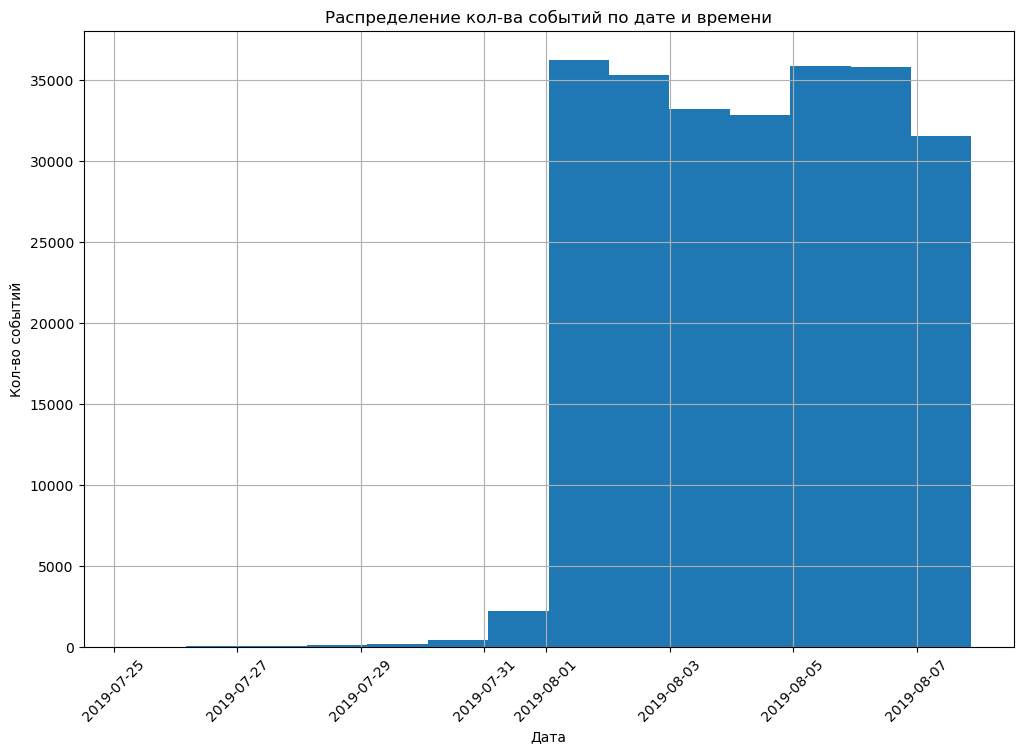

In [34]:
plt.figure(figsize=(12, 8))
data['event_date_time'].hist(bins=14)
plt.title('Распределение кол-ва событий по дате и времени')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Кол-во событий')
plt.show()

Видим, что событий с 25.07 по 31.07 крайне мало. Основную массу событий в логе составляют события периода с 01.08 по 07.08 (период длительностью 7 дней), в каждый день от 31 тысячи до 36 тысячи событий (примерные цифры).

In [35]:
# Определите, с какого момента данные полные и отбросьте более старые
data['event_date'].value_counts().sort_values(ascending=False)

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: event_date, dtype: int64

Похоже, полные данные начинаются с 1 августа, а июльские - можно отбросить.

In [36]:
data = data[data.event_date > date(2019, 7, 31)]

<b> Вывод 3.4: </b> изначально, располагали данными за период с 25 июля 2019 по 07 августа 2019 (14 дней). Но июльские данные неполные, поэтому их отбросили.

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   event_date_time  240887 non-null  datetime64[ns]
 5   event_date       240887 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


In [39]:
print('Стало пользователей в логе -', data['device_id_hash'].nunique())
print('Ушло пользователей - {}'.format(users_count - data['device_id_hash'].nunique()))
print('Это {:.2f}% пользователей'.format((users_count - data['device_id_hash'].nunique()) / users_count * 100))

Стало пользователей в логе - 7534
Ушло пользователей - 17
Это 0.23% пользователей


In [40]:
print('Стало событий в логе -', data.shape[0])
print('Удалили - {}'.format(count_row - data.shape[0]))
print('Это {:.2f}% пользователей'.format((count_row - data.shape[0]) / count_row * 100))

Стало событий в логе - 240887
Удалили - 3239
Это 1.33% пользователей


<b> Вывод 3.5: </b> удалив июльские данные, потеряли немного (1% событий, 0.2% пользователей).

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

In [41]:
data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

In [42]:
data.groupby('exp_id').agg({'device_id_hash' : ['count', 'nunique']})

device_id_hash        
                count nunique
exp_id                       
246             79302    2484
247             77022    2513
248             84563    2537

<b> Вывод 3.6: </b> после удалений в датафрейме остались пользователи всех трех групп эксперимента.

In [43]:
# проверка, что осталось 5 событий
print('Событий в логе -', data['event_name'].nunique())

Событий в логе - 5


In [44]:
# проверка, какое ср. кол-во событий на пользователя
data['device_id_hash'].value_counts().describe()

count    7534.000000
mean       31.973321
std        65.090307
min         1.000000
25%         9.000000
50%        19.000000
75%        37.000000
max      2307.000000
Name: device_id_hash, dtype: float64

<b> ВЫВОД 3 </b> провела исследование данных, получила:
- всего в логе есть 5 событий,
- в логе остались данные за недельный период с 01.08.2019 по 07.08.2019,
- в логе остались данные по 7534 уникальным пользователям (представлены все три экспериментальные группы).

In [45]:
# оставлю контрольный замер
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   exp_id           240887 non-null  int64         
 4   event_date_time  240887 non-null  datetime64[ns]
 5   event_date       240887 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


## Изучение воронки событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте

In [46]:
data['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

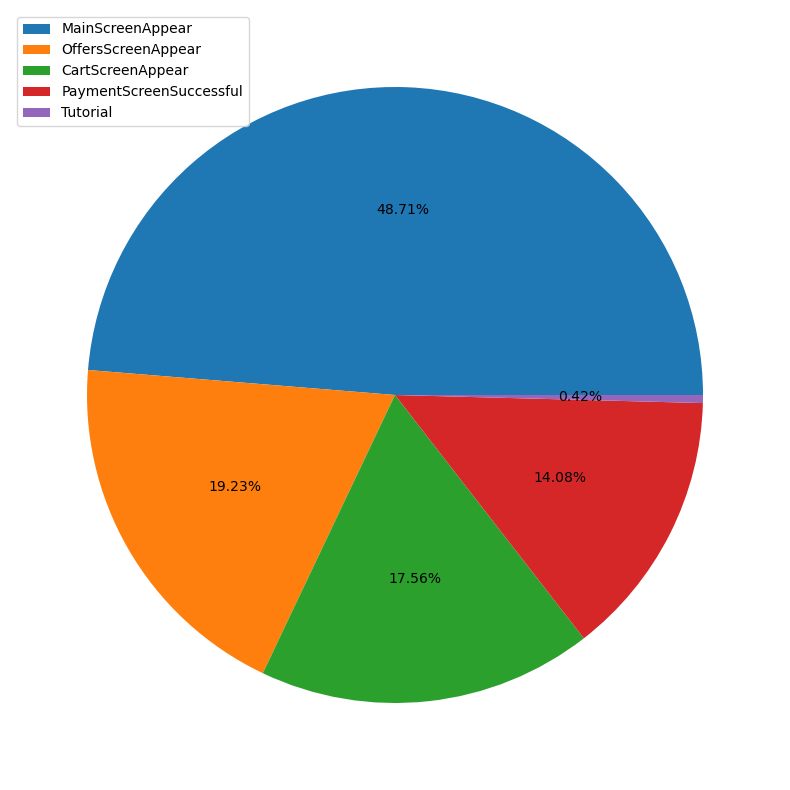

In [47]:
x = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
plt.figure(figsize=(10, 10))
plt.pie(data['event_name'].value_counts(), autopct='%.2f%%')
plt.legend(x)
plt.show()

<b> Вывод 4.1: </b> всего в логах есть 5 событий - MainScreenAppear (показ главного экрана), OffersScreenAppear (показ предложений), CartScreenAppear (показ корзины), PaymentScreenSuccessful (показ экрана успешной оплаты), Tutorial (обучение).

Наиболее часто встречается - MainScreenAppear (почти половина всех показаов первой недели августа 2019). Далее c небольшой разницей между собой - OffersScreenAppear 19.23%, CartScreenAppear 17.56%, PaymentScreenSuccessful 14.08%. Раздел с обучением почти не показывался, только 0.42% (например, его могут пропускать, или он предлагается только новым пользователям, а их было мало на первой неделе август 19./

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие

In [48]:
users_per_event = data.groupby('event_name').agg({'device_id_hash' : 'nunique'})
users_per_event.sort_values(by='device_id_hash', ascending=False)

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Посчитала кол-во пользователей на каждое событие. Наиболее популярным событием среди пользователей оказалось MainScreenAppear. Далее топ совпадает с предыдущим заданием.

In [49]:
nunique_users = data['device_id_hash'].nunique()
users_per_event['share'] = (users_per_event['device_id_hash'] / nunique_users) * 100
users_per_event.sort_values(by='share', ascending=False)

,device_id_hash,share
event_name,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719
Tutorial,840,11.149456


<b> Вывод 4.2: </b> расчитала кол-во пользователей, которые совершали каждое из событий лога, и их долю. 
- 98.5% пользователей первой недели августа 2019г. просматривали главный экран,
- для 61% польз. были показаны спец. предложения,
- 49,5% и 47% пользователей переходили в корзину и оплачивали заказ соответственно,
- 11% польз. было показано обучение.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Логично предположить, что переходы выстраиваются в следующую последовательность:
1. MainScreenAppear (главный экран),
2. OffersScreenAppear (экран спец. предложений),
3. CartScreenAppear (корзина),
4. PaymentScreenSuccessful (экран успешной оплаты).

Демо приложения (Tutorial) не очень встает в эту последовательность. Предположу, что он показывается только новым пользователям, тогда это событие встало бы до или после главного экрана.

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Для расчета приму следующую последовательность: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful.

In [50]:
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
funnel_data = data[data.event_name.isin(funnel_events)]
funnel_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date_time,event_date
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01


In [51]:
grouped_funnel_data = funnel_data.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending = False)
grouped_funnel_data

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [52]:
grouped_funnel_data['share'] = (grouped_funnel_data['device_id_hash'] / grouped_funnel_data['device_id_hash'].shift(1)) * 100
grouped_funnel_data

,device_id_hash,share
event_name,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,61.908613
CartScreenAppear,3734,81.297627
PaymentScreenSuccessful,3539,94.777718


<b> Вывод 4.4: </b> по воронке событий расчитала доли пользователей при переходе с одного события на другой (не учитывалось событие Tutorial, т.к. он не совсем вписывается в последоватьность событий):
1. 61.9% пользователей переходят с MainScreenAppear на OffersScreenAppear;
2. 81.3% пользователей осуществляют переход OffersScreenAppear -> CartScreenAppear;
3. 94.8% пользователей осуществляют переход CartScreenAppear -> PaymentScreenSuccessful.

### На каком шаге теряете больше всего пользователей?

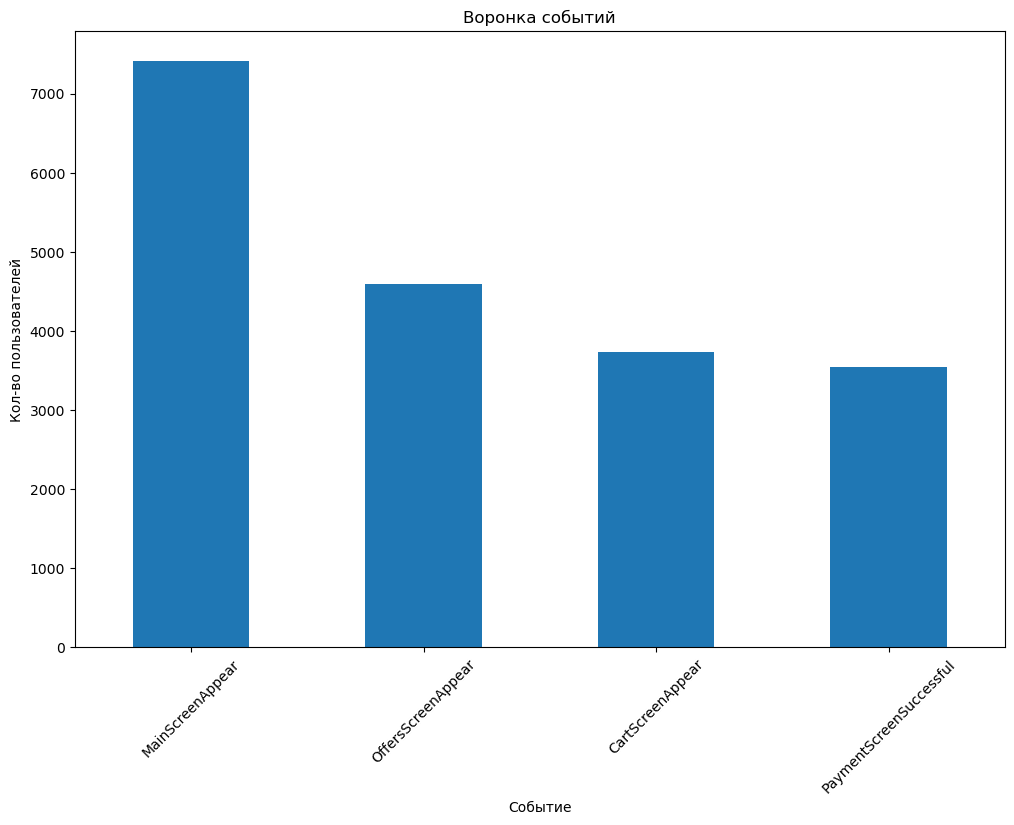

In [53]:
# по численным данным предполагаю, что больше всего теряется между 1 и 2 событиями в последовательности
# построим столбчатую диаграмму
plt.figure(figsize=(12, 8))
grouped_funnel_data['device_id_hash'].plot(kind='bar')
plt.title('Воронка событий')
plt.xlabel('Событие')
plt.xticks(rotation=45)
plt.ylabel('Кол-во пользователей')
plt.show()

In [54]:
grouped_funnel_data['dif'] = grouped_funnel_data['device_id_hash'] - grouped_funnel_data['device_id_hash'].shift(1)
grouped_funnel_data

,device_id_hash,share,dif
event_name,,,
MainScreenAppear,7419,NaN,NaN
OffersScreenAppear,4593,61.908613,-2826.0
CartScreenAppear,3734,81.297627,-859.0
PaymentScreenSuccessful,3539,94.777718,-195.0


<b> Вывод 4.5: </b> больше всего пользователей теряется на первом переходе MainScreenAppear -> OffersScreenAppear.

### Какая доля пользователей доходит от первого события до оплаты?

In [55]:
print('Доля пользователей, проходящая путь от главного экрана до оплаты, - {:.2f}%'
      .format(grouped_funnel_data.loc['PaymentScreenSuccessful', 'device_id_hash'] / grouped_funnel_data.loc['MainScreenAppear', 'device_id_hash'] * 100))

Доля пользователей, проходящая путь от главного экрана до оплаты, - 47.70%


<b> Вывод 4.6: </b> Доля пользователей, проходящая путь от главного экрана до оплаты, - 47.70%

<b> ВЫВОД 4 </b> провела исследование воронки событий.
1. Всего в логах есть 5 событий. Наиболее часто встречается - MainScreenAppear (почти половина всех показаов первой недели августа 2019). Далее c небольшой разницей между собой - OffersScreenAppear 19.23%, CartScreenAppear 17.56%, PaymentScreenSuccessful 14.08%. Раздел Tutorial почти не показывался - 0.42%.
2. расчитала кол-во пользователей, которые совершали каждое из событий лога, и их долю:
    - 98.5% пользователей первой недели августа 2019г. просматривали главный экран,
    - для 61% польз. были показаны спец. предложения,
    - 49,5% и 47% пользователей переходили в корзину и оплачивали заказ соответственно,
    - 11% польз. было показано обучение.
3. Предпопложила последовательность событий: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. 
4. Событие Tutorial не совсем вписывается в последовательность, предпоплагаю, что этот этап показывается только новым пользователя до или после главного экрана при первом запуске.
5. Расчитатала, что больше всего пользователей теряется при первом переходе: MainScreenAppear -> OffersScreenAppear.
6. При этом доля пользователей, прошедших от главного экрана до успешной оплаты, - 47.7%.
7. Если сравнивать кол-во пользователей между соседними событиями, то:
    - 61.9% пользователей переходят с MainScreenAppear на OffersScreenAppear;
    - 81.3% пользователей осуществляют переход OffersScreenAppear -> CartScreenAppear;
    - 94.8% пользователей осуществляют переход CartScreenAppear -> PaymentScreenSuccessful

## Изучение результатов А/А/В-теста

### Сколько пользователей в каждой экспериментальной группе?

In [56]:
data.groupby('exp_id').agg({'device_id_hash' : ['count', 'nunique']})

device_id_hash        
                count nunique
exp_id                       
246             79302    2484
247             77022    2513
248             84563    2537

<b> Вывод 5.1: </b> в каждой экпериментальной группе около 2.5 тыс. пользователей.

Далее по заданию необходимо будет проводить множество проверок, есть ли стат. значимость между различными выборками. Поэтому напишем функцию.

Для проверки нам необходимы:
1. Кол-во уникальных пользователей в сравниваемых группах,
2. Кол-во пользователей, прошедших событие.

In [57]:
def test(users, events, alpha):
    
    p1 = events[0] / users[0] # доля для 1 группы
    p2 = events[1] / users[1] # доля для 2 группы
        
    p_combined = sum(events) / sum(users) 
        
    difference = p1 - p2
        
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1])
    )
        
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
        
    print('p-value:', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')

### А/А-тест

In [58]:
pop_events = data.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
pop_events

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [59]:
# сравниваемые экспериментальные группы и уровень стат. значимости
group_ids = [246, 247]
alpha = 0.05

In [60]:
# кол-во уникальных пользователей в группах 246 и 247
users_per_group = [data.query('exp_id == @group_id')['device_id_hash'].nunique() for group_id in group_ids]
users_per_group

[2484, 2513]

#### Событие Tutorial

- Н0: Различия между группами 246 и 247 по событию Tutorial статистически НЕ значимы.
- Н1: Различия между группами 246 и 247 по событию Tutorial статистически значимы.

(остальные гипотезы выдвигались по такому же принципу)

In [61]:
# кол-во польз. из группы на событии
the_event = 'Tutorial'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)
users_per_event

[278, 283]

In [62]:
test(users_per_group, users_per_event, alpha)

p-value: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу.


#### Событие MainScreenAppear

In [63]:
# кол-во польз. из группы на событии
the_event = 'MainScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)
users_per_event

[2450, 2476]

In [64]:
test(users_per_group, users_per_event, alpha)

p-value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу.


#### Событие OffersScreenAppear

In [65]:
# кол-во польз. из группы на событии
the_event = 'OffersScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)
users_per_event

[1542, 1520]

In [66]:
test(users_per_group, users_per_event, alpha)

p-value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу.


#### Событие CartScreenAppear

In [67]:
# кол-во польз. из группы на событии
the_event = 'CartScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)
users_per_event

[1266, 1238]

In [68]:
test(users_per_group, users_per_event, alpha)

p-value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу.


#### Событие PaymentScreenSuccessful

In [69]:
# кол-во польз. из группы на событии
the_event = 'PaymentScreenSuccessful'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)
users_per_event

[1200, 1158]

In [70]:
test(users_per_group, users_per_event, alpha)

p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу.


<b> Вывод 5.2: </b> провела А/А-тест. Получила, что нет статистически значимых различий между контрольными группами 246 и 247 по всем событиям. Можно сказать, что пользователи распределились однородно между группами А/А/В-теста, и приступать к проверке экспериментальной группы 248.

### A/B-тест

Необходимо попарно сравнить: 246-248, 247-248, (246+247)-248, и уже было 246-247. 

Так это множественное сравнение, то необходимо внести поправку к статистической значимости. 

Всего у нас 5 событий и 4 сравнения, то есть 20. Использую поправку Бонферрони.

In [71]:
alpha = alpha / 20 # поправка Бонферрони уровня стат. значимости

#### Группы 246 и 248

In [72]:
# сравниваемые экспериментальные группы
group_ids = [246, 248]

# кол-во уникальных пользователей в группах 246 и 248
users_per_group = [data.query('exp_id == @group_id')['device_id_hash'].nunique() for group_id in group_ids]

Событие Tutorial
- Н0: Различия между группами 246 и 248 по событию Tutorial статистически НЕ значимы.
- Н1: Различия между группами 246 и 248 по событию Tutorial статистически значимы.

(остальные гипотезы выдвигались по такому же принципу)

In [73]:
# кол-во польз. из группы на событии
the_event = 'Tutorial'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу.


In [74]:
# Событие MainScreenAppear

# кол-во польз. из группы на событии
the_event = 'MainScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу.


In [75]:
# Событие OffersScreenAppear

# кол-во польз. из группы на событии
the_event = 'OffersScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу.


In [76]:
# Событие CartScreenAppear

# кол-во польз. из группы на событии
the_event = 'CartScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу.


In [77]:
# Событие PaymentScreenSuccessful

# кол-во польз. из группы на событии
the_event = 'PaymentScreenSuccessful'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу.


<b> Вывод 5.3.1: </b> нет статистически значимых различий между группами 246 и 248 по всем событиям.

#### Группы 247 и 248

In [78]:
# сравниваемые экспериментальные группы
group_ids = [247, 248]

# кол-во уникальных пользователей в группах 247 и 248
users_per_group = [data.query('exp_id == @group_id')['device_id_hash'].nunique() for group_id in group_ids]

Событие Tutorial
- Н0: Различия между группами 247 и 248 по событию Tutorial статистически НЕ значимы.
- Н1: Различия между группами 247 и 248 по событию Tutorial статистически значимы.

(остальные гипотезы выдвигались по такому же принципу)

In [79]:
# кол-во польз. из группы на событии
the_event = 'Tutorial'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу.


In [80]:
# Событие MainScreenAppear

# кол-во польз. из группы на событии
the_event = 'MainScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу.


In [81]:
# Событие OffersScreenAppear

# кол-во польз. из группы на событии
the_event = 'OffersScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу.


In [82]:
# Событие CartScreenAppear

# кол-во польз. из группы на событии
the_event = 'CartScreenAppear'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу.


In [83]:
# Событие PaymentScreenSuccessful

# кол-во польз. из группы на событии
the_event = 'PaymentScreenSuccessful'
users_per_event = (
    [data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу.


<b> Вывод 5.3.2: </b> нет статистически значимых различий между группами 247 и 248 по всем событиям.

#### Группы 246+247 и 248

In [84]:
combined_data = data.copy() # копировала датафрейм
combined_data['exp_id'].replace({247: 246}, inplace=True) # переименовала 247 группу в 246
combined_data['exp_id'].value_counts() # в датафрейме оставила группу 246, значит, буду сравнивать 246 и 248

246    156324
248     84563
Name: exp_id, dtype: int64

In [85]:
# сравниваемые экспериментальные группы
group_ids = [246, 248]

# кол-во уникальных пользователей в группах 246+247 и 248
users_per_group = [combined_data.query('exp_id == @group_id')['device_id_hash'].nunique() for group_id in group_ids]

Событие Tutorial
- Н0: Различия между группами 246+247 и 248 по событию Tutorial статистически НЕ значимы.
- Н1: Различия между группами 246+247 и 248 по событию Tutorial статистически значимы.

(остальные гипотезы выдвигались по такому же принципу)

In [86]:
# кол-во польз. из группы на событии
the_event = 'Tutorial'
users_per_event = (
    [combined_data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу.


In [87]:
# Событие MainScreenAppear

# кол-во польз. из группы на событии
the_event = 'MainScreenAppear'
users_per_event = (
    [combined_data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу.


In [88]:
# Событие OffersScreenAppear

# кол-во польз. из группы на событии
the_event = 'OffersScreenAppear'
users_per_event = (
    [combined_data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу.


In [89]:
# Событие CartScreenAppear

# кол-во польз. из группы на событии
the_event = 'CartScreenAppear'
users_per_event = (
    [combined_data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу.


In [90]:
# Событие PaymentScreenSuccessful

# кол-во польз. из группы на событии
the_event = 'PaymentScreenSuccessful'
users_per_event = (
    [combined_data.query('exp_id == @group_id and event_name == @the_event')['device_id_hash'].nunique() for group_id in group_ids]
)

test(users_per_group, users_per_event, alpha)

p-value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу.


<b> Вывод 5.3.3: </b> нет статистически значимых различий между группами 246+247 и 248 по всем событиям.

<b> Вывод 5: </b> изучены результаты А/А/В-теста. 
1. Проверены контрольные группы (А/А-тест), нет статистически значимых разниц между группами, поэтому был сделан вывод, что группы подобраны корректно. 
2. Проведены попарные сравнения между контрольными и экспериментальными группами, а также объединенной контрольной и экспериментальной. Не выявлено статистически значимых разниц между группами.

<b> Вывод по кейсу: </b>

Напоминаю ситуацию по кейсу: "Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно".

По результатам А/А/В-теста фиксирую отсутствие различий между группами с новыми и старыми шрифтам. 

Значит, смена шрифтов не должна повлиять на использование приложения.